In [76]:
import requests, time
from urllib.parse import quote
import pandas as pd
from bs4 import BeautifulSoup
import re
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from tqdm import tqdm
import folium

In [2]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
# service = Service('C:/Users/YONSAI/Downloads/chromedriver_win32/chromedriver.exe')
# driver = webdriver.Chrome(service=service)
# url= 'https://www.ggpolice.go.kr/main/html.do?menu=HC44'
# driver.get(url)

In [3]:
header = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36'}
base_url = 'https://www.ggpolice.go.kr'
main_url = '/main/html.do?menu=HC44'
url = f'{base_url}{main_url}'
res = requests.get(url,headers=header)
soup = BeautifulSoup(res.text)

In [4]:
lis = soup.select('.road')
len(lis)

31

In [44]:
li = lis[19]

In [45]:
href = li.select_one('.road > a')['href']
href = href[26:]
href

'/hsdt/html.do?menu=HC24'

In [46]:
sub_url = f'{base_url}{href}'
res = requests.get(sub_url)
caps_soup = BeautifulSoup(res.text)

In [ ]:
def road_addr(add):
    addr = addr.replace('(',' ').split(' ')[3:-1]
    addr = ' '.join(addr)
    return addr

In [64]:
# addr = caps_soup.select('.basic_list7 > li')[1].get_text().replace('(',' ').split(' ')[3:-1]
addr = ' '.join(caps_soup.select('.basic_list7 > li')[1].get_text().replace('(',' ').split(' ')[3:-1])
addr

'경기 하남시 검단로 27 '

In [56]:
name = caps_soup.select('.basic_list7 > li')[0].get_text()[6:].strip()
name

'수원중부경찰서'

In [65]:
lines = []
for li in tqdm(lis):
    try:
        href = li.select_one('.road > a')['href']
        href = href[26:]
        sub_url = f'{base_url}{href}'
        res = requests.get(sub_url)
        caps_soup = BeautifulSoup(res.text)
        name = caps_soup.select('.basic_list7 > li')[0].get_text()[6:].strip()
        addr = ' '.join(caps_soup.select('.basic_list7 > li')[1].get_text().replace('(',' ').split(' ')[3:-1])
        lines.append({'기관명':name,'주소':addr})
    except:
        continue

100%|██████████| 31/31 [00:08<00:00,  3.82it/s]


In [59]:
df = pd.DataFrame(lines)
df.head(30).tail(10)

""


In [60]:
df.to_csv('data/caps_addr.csv',index=False)
pd.read_csv('data/caps_addr.csv').tail()

EmptyDataError: No columns to parse from file

In [66]:
lines = []
for li in tqdm(lis):
    try:
        href = li.select_one('.road > a')['href']
        href = href[26:]
        sub_url = f'{base_url}{href}'
        res = requests.get(sub_url)
        caps_soup = BeautifulSoup(res.text)
        name = caps_soup.select('.basic_list7 > li')[0].get_text()[6:].strip()
        addr = ' '.join(caps_soup.select('.basic_list7 > li')[1].get_text().replace('(',' ').split(' ')[3:-1])
        if not any(line['기관명'] == name for line in lines):
            lines.append({'기관명':name,'주소':addr})
    except:
        print(li)

100%|██████████| 31/31 [00:08<00:00,  3.82it/s]


In [67]:
df2 = pd.DataFrame(lines)
df2.tail()

,기관명,주소
23,안성경찰서,경기 안성시 알미산로 140
24,여주경찰서,경기 여주시 세종로 50
25,양평경찰서,경기도 양평군 옥천면 고읍로 88
26,의왕경찰서,경기 의왕시 오봉로 10
27,하남경찰서,경기 하남시 검단로 27


In [68]:
df2.to_csv('data/caps_addr.csv',index=False)
pd.read_csv('data/caps_addr.csv').tail()

,기관명,주소
23,안성경찰서,경기 안성시 알미산로 140
24,여주경찰서,경기 여주시 세종로 50
25,양평경찰서,경기도 양평군 옥천면 고읍로 88
26,의왕경찰서,경기 의왕시 오봉로 10
27,하남경찰서,경기 하남시 검단로 27


In [70]:
with open('../04.지도시각화/data/kakaoapikey.txt') as f:
    kakao_key = f.read()

In [71]:
base_url = "https://dapi.kakao.com/v2/local/search/address.json"
addr = ''
url = f'{base_url}?query={quote(addr)}'
url

'https://dapi.kakao.com/v2/local/search/address.json?query='

In [72]:
k_header = {'Authorization':f'KakaoAK {kakao_key}'}

In [73]:
lat_list = []
lng_list = []
for i in tqdm(df2.index):
    try:
        url = f'{base_url}?query={quote(df2.주소[i])}'
        result = requests.get(url, headers=k_header).json()
        lat_list.append(float(result['documents'][0]['y']))
        lng_list.append(float(result['documents'][0]['x']))
    except:
        print(df2.기관명[i], df2.주소[i])

100%|██████████| 28/28 [00:01<00:00, 15.25it/s]


In [78]:
df2['위도'] = lat_list
df2['경도'] = lng_list
df2.head()


,기관명,주소,위도,경도
0,수원중부경찰서,경기도 수원시 장안구 정자천로 199,37.297932,126.996317
1,수원남부경찰서,경기 수원시 영통구 매봉로 52,37.272104,127.054492
2,수원서부경찰서,경기 수원시 권선구 서부로 1673,37.258740,126.972264
3,안양동안경찰서,경기도 안양시 동안구 동안로159번길 43,37.391209,126.948866
4,안양만안경찰서,경기도 안양시 만안구 냉천로 63,37.387334,126.925974



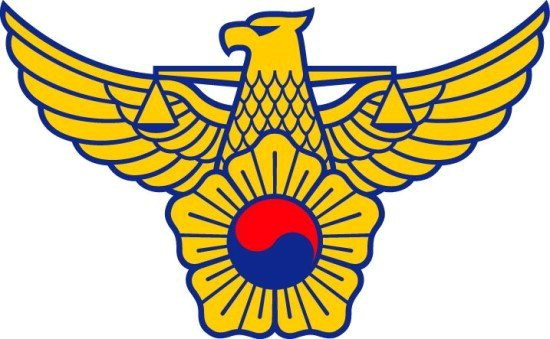
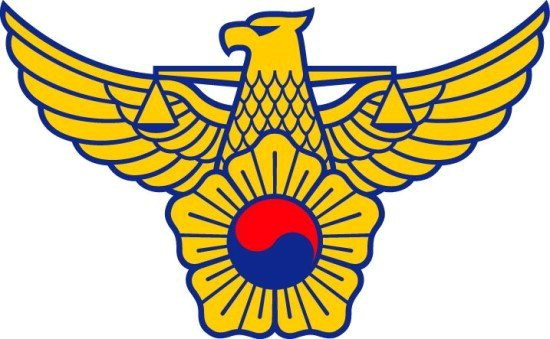
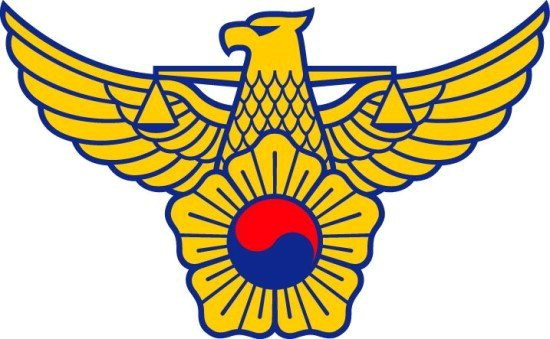
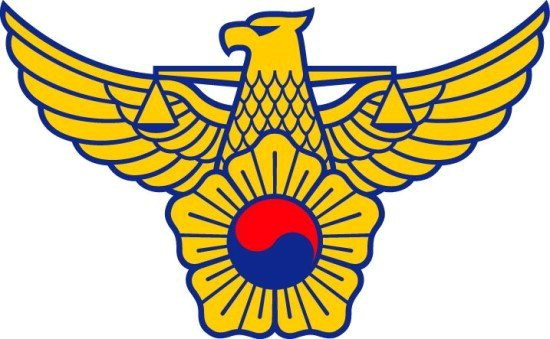
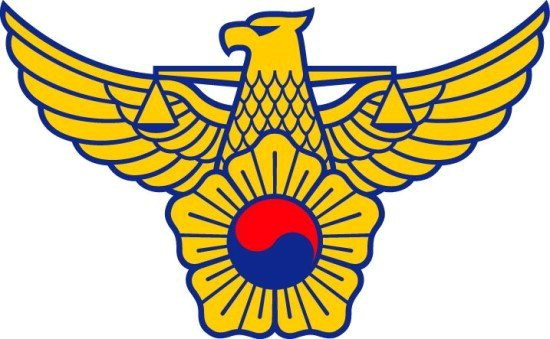
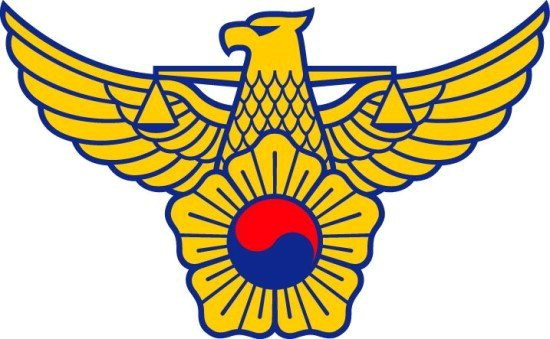
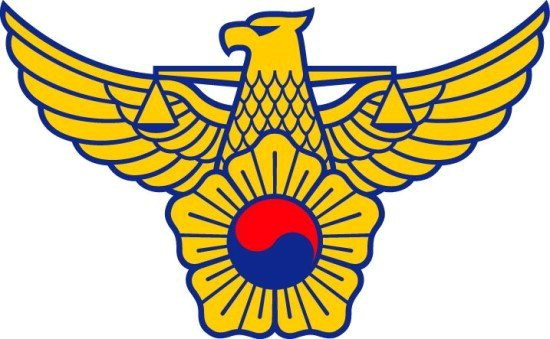
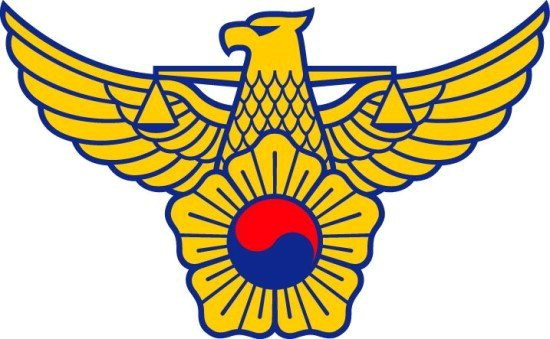
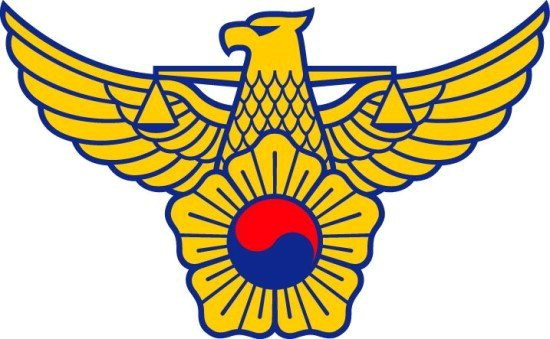
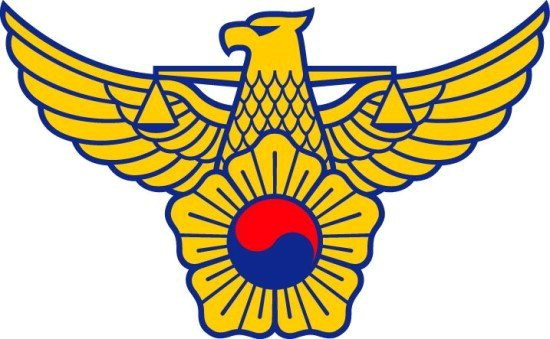
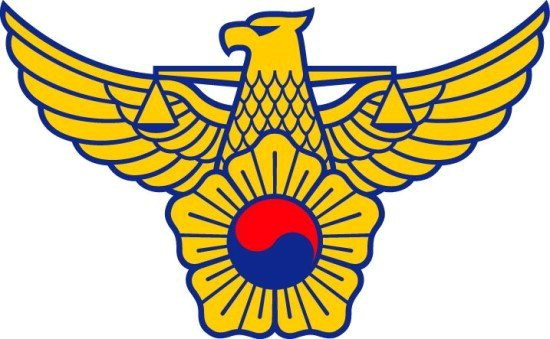
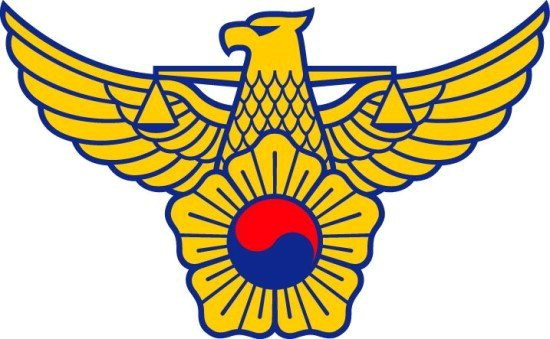
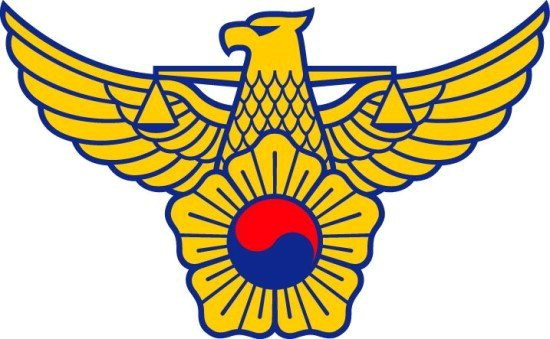
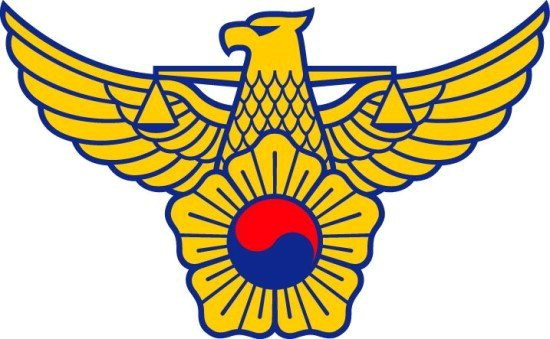
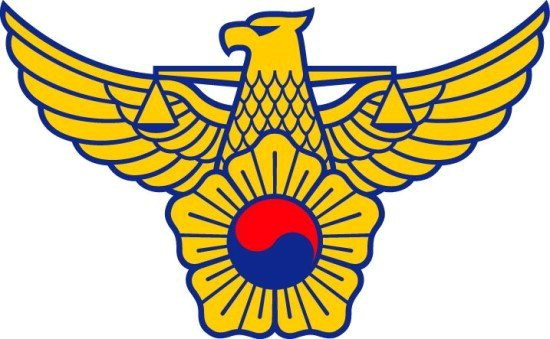
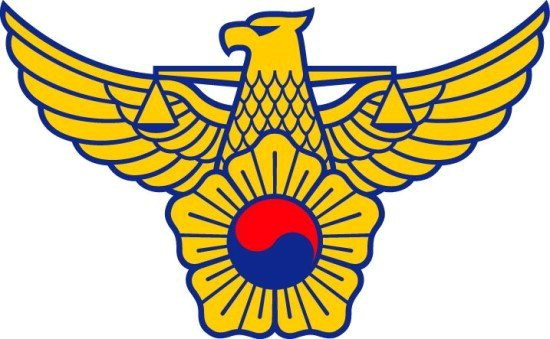
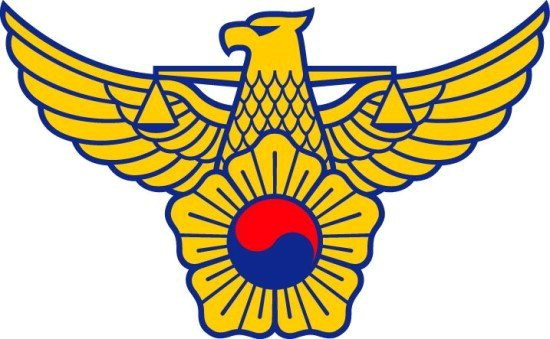
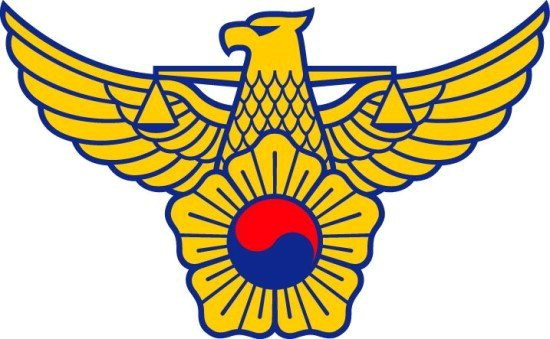
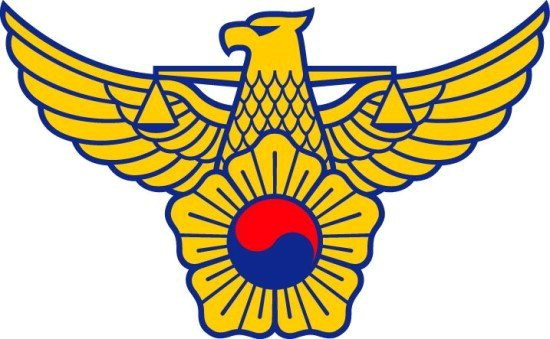
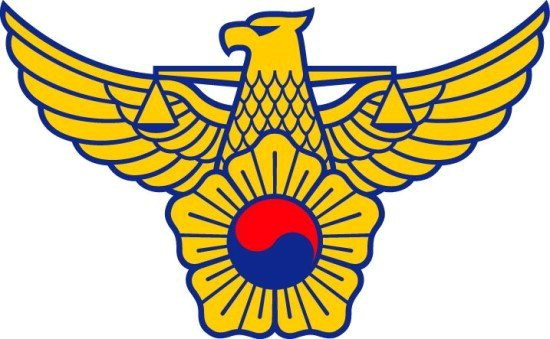
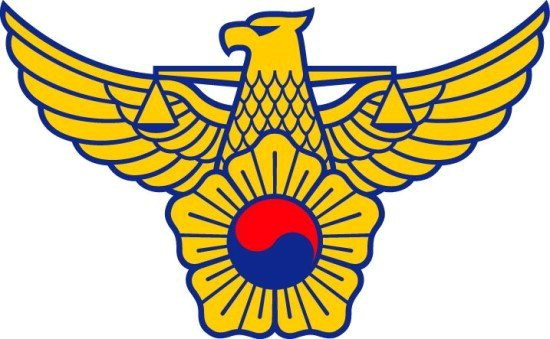
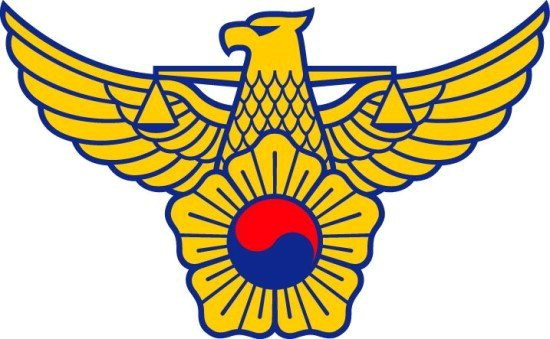
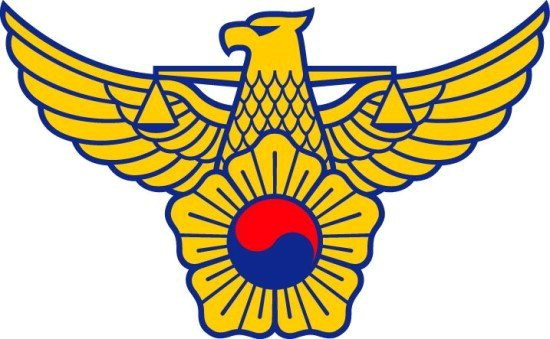
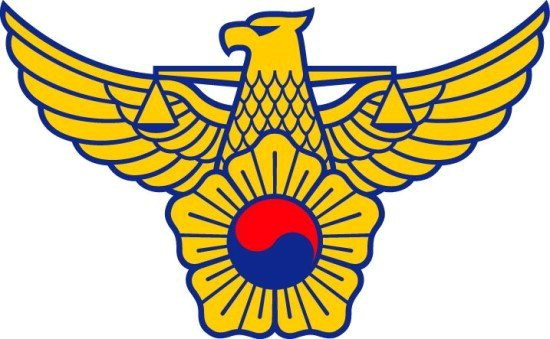
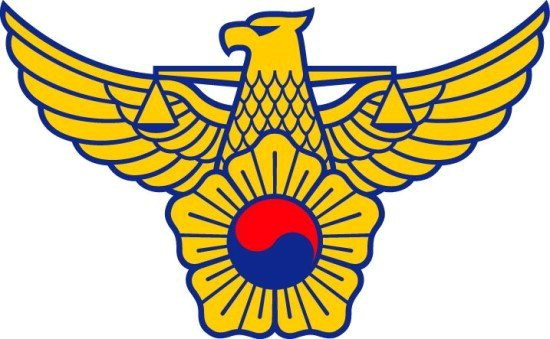
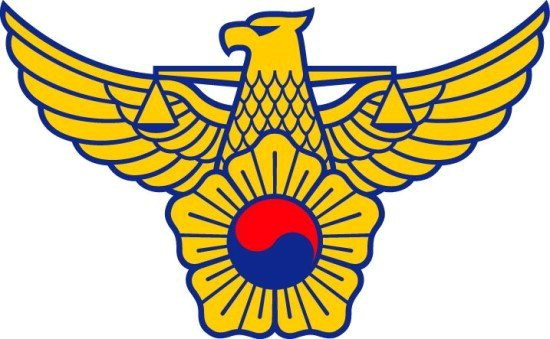
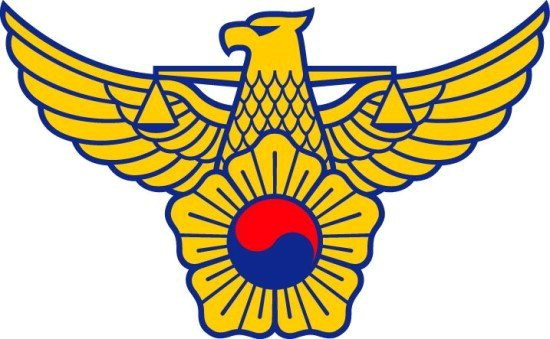
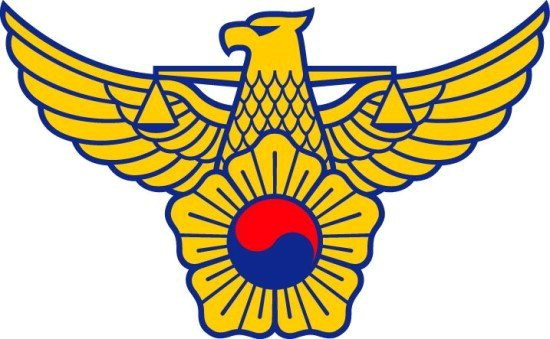

In [81]:
caps_addr_map = folium.Map(location=[df2.위도.mean(),df2.경도.mean()],zoom_start=10)
for i in df2.index:
    pushpin = folium.CustomIcon('data/logo.jpg', icon_size=(40,40))
    folium.Marker(
        location=[df2.위도[i], df2.경도[i]],                     
        popup=folium.Popup(df2.주소[i],max_width=200),
        tooltip=df2.기관명[i],
        icon=pushpin
    ).add_to(caps_addr_map)
title_html = '<h3 align="center" style="font-size:20px">경기 남부 경찰서</h3>'
caps_addr_map.get_root().html.add_child(folium.Element(title_html))
caps_addr_map